In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
WORKLOAD = "WITH_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

In [3]:
def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs
runs = get_runs()

[("function_name":"time")]

In [4]:
def json_extract(obj):
    arr = []

    def extract(obj, arr):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr)
                elif k == "function_name":
                    key = v
                elif k == "time":
                    val = v
                    arr.append((key,val))
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr)
        return arr

    values = extract(obj, arr)
    return values

json_extract(runs)


[('do_syscall_64() ', 26.56),
 ('__x64_sys_write();', 25.578),
 ('fpregs_assert_state_consistent();', 0.181),
 ('do_syscall_64() ', 10038.42),
 ('__x64_sys_epoll_wait() ', 10037.13),
 ('fpregs_assert_state_consistent();', 0.18),
 ('switch_fpu_return();', 0.311),
 ('do_syscall_64() ', 17.513),
 ('__x64_sys_accept4();', 16.751),
 ('fpregs_assert_state_consistent();', 0.17),
 ('do_syscall_64() ', 17.934),
 ('__x64_sys_write();', 17.202),
 ('fpregs_assert_state_consistent();', 0.161),
 ('do_syscall_64() ', 10336.1),
 ('__x64_sys_epoll_wait() ', 10334.53),
 ('fpregs_assert_state_consistent();', 0.271),
 ('switch_fpu_return();', 0.321),
 ('do_syscall_64() ', 16.361),
 ('__x64_sys_accept4();', 15.499),
 ('fpregs_assert_state_consistent();', 0.201),
 ('do_syscall_64() ', 22.772),
 ('__x64_sys_write();', 21.961),
 ('fpregs_assert_state_consistent();', 0.231),
 ('do_syscall_64() ', 9459.672),
 ('__x64_sys_epoll_wait() ', 9457.869),
 ('fpregs_assert_state_consistent();', 0.511),
 ('switch_fpu_ret

{"function_name":"max time in the entire trace"}

In [5]:
def json_extract(obj):
    d = dict()

    def extract(obj, arr):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr)
                elif k == "function_name":
                    dkey = v
                elif k == "time":
                    dval = v
                    if (dkey in d and dval > d[dkey]):
                        d[dkey] = dval
                    elif dkey not in d:
                        d[dkey] = dval
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr)
        return arr

    values = extract(obj, d)
    return values

d = json_extract(runs)
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}
filtered_dict = {k:v for k,v in d.items() if k not in FUNC_BLACKLIST}
print(sum(d.values()))

82328579.62199995


{"function_name":"add all the time corresponding to a certain function"}

In [6]:
def json_extract(obj):
    d = dict()

    def extract(obj, arr):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr)
                elif k == "function_name":
                    dkey = v.strip().strip(";")
                elif k == "time":
                    dval = v
                    if dkey in d:
                        d[dkey] = d.get(dkey,0) + dval
                    else:
                        d[dkey] = dval
                    
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr)
        return arr

    values = extract(obj, d)
    return values

d = json_extract(runs)
FUNC_BLACKLIST = ['BLANK', 'do_syscall_64()','switch_mm_irqs_off()','__x64_sys_epoll_wait()']

filtered_dict = dict(filter(lambda elem: elem[0] not in FUNC_BLACKLIST, d.items()))


function_name vs total time in the trace

<BarContainer object of 20 artists>

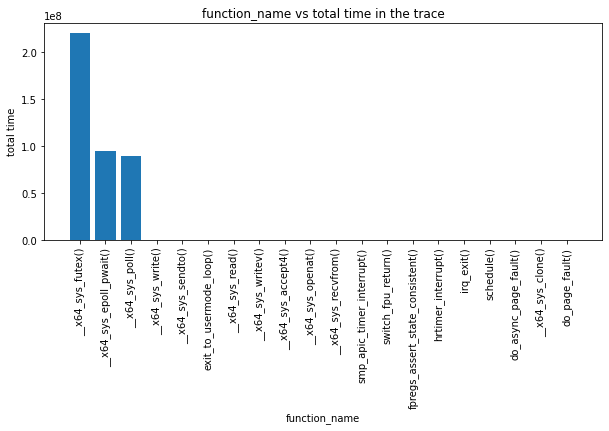

In [7]:
filtered_dict = {k: v for k, v in sorted(filtered_dict.items(), key=lambda item: item[1],reverse=True)}
l = list(filtered_dict.items())[:20]
X = [x[0] for x in l]
Y = [y[1] for y in l]

plt.figure(figsize=(10, 4))
plt.xticks(np.arange(len(X)), X, rotation=90)
plt.title("function_name vs total time in the trace")
plt.xlabel("function_name")
plt.ylabel("total time")
plt.bar(X,Y)

fraction of time each function takes in the total trace time

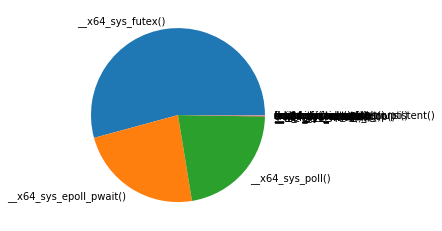

In [8]:
trace_time = 100*10**6
Y = [(y/trace_time)*100 for y in Y]
plt.pie(Y,labels = X)
plt.show()


time difference between the functions of the 0th run and 1st run, 0th run and the 2nd run, 1st run and the 0th run ...... 

In [9]:
def get_time_diff(d):
    time_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            time_diff[f"{i}-{j}"]= {}
            for function in d[i].keys():
                lhs = d[i].get(function, 0) 
                rhs = d[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                time_diff[f"{i}-{j}"][function] = lhs - rhs
    return time_diff
  

runs = [{runs[0]}, {runs[1]}, {runs[2]}]

In [10]:
json_extract_output_runs = []
for r in runs:
    json_extract_output_runs.append(json_extract(r))

FUNC_BLACKLIST = ['BLANK', 'do_syscall_64()','switch_mm_irqs_off()','__x64_sys_epoll_wait()']

for i in range(0,len(json_extract_output_runs)):
    json_extract_output_runs[i] = dict(filter(lambda elem: elem[0] not in FUNC_BLACKLIST, json_extract_output_runs[i].items()))
time_diff = get_time_diff(json_extract_output_runs)

print([(x, time_diff["2-1"][x]) for x in sorted(time_diff["2-1"], key=lambda x: time_diff["2-1"][x], reverse=True)])

[('__x64_sys_poll()', 9994677.0), ('__x64_sys_read()', 1355.820000000036), ('__x64_sys_writev()', 1199.075000000001), ('__x64_sys_sendto()', 1122.686999999999), ('schedule()', 910.6369999999997), ('__x64_sys_readv()', 652.2460000000001), ('__x64_sys_write()', 390.7870000000403), ('__x64_sys_recvfrom()', 344.86900000000026), ('do_async_page_fault()', 319.32299999999987), ('do_page_fault()', 305.4069999999999), ('__x64_sys_connect()', 84.88000000000014), ('__x64_sys_nanosleep()', 78.67500000000001), ('__x64_sys_newfstatat()', 49.74300000000002), ('__x64_sys_epoll_ctl()', 33.664000000000016), ('__x64_sys_setsockopt()', 6.2829999999999995), ('load_new_mm_cr3()', 5.208000000000027), ('__x64_sys_getsockopt()', 4.779), ('__ia32_sys_sched_yield()', 4.608), ('__x64_sys_getpeername()', 3.637), ('__rseq_handle_notify_resume()', 2.896), ('do_signal()', 2.5150000000000006), ('smp_reschedule_interrupt()', 2.503), ('__x64_sys_getsockname()', 2.4129999999999896), ('__ia32_sys_rt_sigreturn()', 1.952), 

What functions are common between all the runs

In [11]:
for i in range(NUM_RUNS):
    common_functions = {x:json_extract_output_runs}

NameError: name 'x' is not defined

For each pid sort functions at each level sorted by time

In [56]:
def json_extract(obj):
    arr = []
    if(isinstance(obj, dict)):
        level = -1
    else:
        level = 0

    def extract(obj, arr,level):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, list):
                    extract(v, arr, level+1)
                elif k == "function_name":
                    dkey = v
                elif k == "time":
                    dval = v
                    if (dkey in arr[level] and dval > arr[level][dkey]):
                        arr[level][dkey] = dval
                    elif dkey not in arr[level]:
                        arr[level][dkey] = dval

        elif isinstance(obj, list):
            #print(level,len(arr))
            if(level == len(arr)):
                arr.append(dict())
            for item in obj:
                extract(item, arr, level)
        return arr

    values = extract(obj, arr, level)
    return values

json_extract(r1)

[{'do_syscall_64() ': 9840.515},
 {'__x64_sys_epoll_wait() ': 9839.354},
 {'do_epoll_wait() ': 9838.602},
 {'__fdget() ': 0.531},
 {'__fget_light();': 0.22},
 {}]

In [68]:
for pid,temp_dict in r1.items():
    #print(pid)
    arr_of_levelwise_dicts = json_extract(temp_dict)
    print(pid)
    for i,temp in enumerate(arr_of_levelwise_dicts):
        print(i,temp)

''' for each_run in runs:
    for pid,temp_dict in each_run.items():
        #print(pid)
        arr_of_levelwise_dicts = json_extract(temp_dict)
        for i,temp in enumerate(arr_of_levelwise_dicts):
            temp = sorted(temp,key = lambda x: x[1], reverse= True)
            print(i,temp) '''
    


3070430
0 {'do_syscall_64() ': 9840.515}
1 {'__x64_sys_epoll_wait() ': 9839.354}
2 {'do_epoll_wait() ': 9838.602}
3 {'__fdget() ': 0.531}
4 {'__fget_light();': 0.22}
5 {}
3070431
0 {'do_syscall_64() ': 9840.515}
1 {'__x64_sys_epoll_wait() ': 9839.354}
2 {'do_epoll_wait() ': 9838.602}
3 {'__fdget() ': 0.531}
4 {'__fget_light();': 0.22}
5 {}


In [61]:
r = {
  "1567889": [
    {
      "function_name": "do_syscall_64() ",
      "time": 26.56,
      "children": [
        {
          "function_name": "__x64_sys_write();",
          "time": 25.578,
          "children": []
        },
        {
          "function_name": "fpregs_assert_state_consistent();",
          "time": 0.181,
          "children": []
        }
      ]
    },
    {
      "function_name": "do_syscall_64() ",
      "time": 10038.42,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 10037.13,
          "children": []
        },
        {
          "function_name": "fpregs_assert_state_consistent();",
          "time": 0.18,
          "children": []
        },
        {
          "function_name": "switch_fpu_return();",
          "time": 0.311,
          "children": []
        }
      ]
    }]}
r1 = {
  "3070430": [
    {
      "function_name": "do_syscall_64() ",
      "time": 9840.515,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 9839.354,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 9838.602,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.531,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.22,
                      "children": []
                    }
                  ]
                }]}]}]}],
    "3070431": [
    {
      "function_name": "do_syscall_64() ",
      "time": 9840.515,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 9839.354,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 9838.602,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.531,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.22,
                      "children": []
                    }
                  ]
                }]}]}]}]}
r2 = [
    {
      "function_name": "do_syscall_64() ",
      "time": 9840.515,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 9839.354,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 9838.602,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.531,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.22,
                      "children": []
                    }
                  ]
                }]}]}]}]